In [1]:


%load_ext autoreload
%autoreload 2

import sys
import cv2
sys.path.append('../')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
import argparse
import gc
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import glob
from util.data_util import *
from util.utils import process_image, colorize_mask
import json
from train_deeplab import ImageLabelDataset, ImageDataset
import scipy.misc
from pathlib import Path
import imageio

import matplotlib.pyplot as plt


In [2]:

from torch.utils.data import Dataset, DataLoader
import glob
from torchvision import transforms
from PIL import Image
from util.data_util import *
import json
import pickle

from pathlib import Path

from collections import defaultdict
import ipdb

In [3]:
!pwd

/mnt/lustre/yslan/Repo/3D/generative/datasetGAN_release/datasetGAN


In [4]:
def load_cfg(args):
    if args['category'] == 'car':
        from util.data_util import car_20_palette as palette
        if args['testing_data_number_class'] == 12:
            from util.data_util import car_12_class as class_name
        elif args['testing_data_number_class'] == 20:
            from util.data_util import car_20_class as class_name
    elif args['category'] == 'face':
        from util.data_util import face_palette as palette
        from util.data_util import face_class as class_name

    elif args['category'] == 'bedroom':
        from util.data_util import bedroom_palette as palette
    elif args['category'] == 'cat':
        from util.data_util import cat_palette as palette
        class_name=None
        
    print(args['category'])
        
    return class_name, palette


import ipdb

def inference(ckpt, args, save=True, blur=True, ksize=31, std=33, class_name_to_ignore=None):

    class_name, palette = load_cfg(args)
    ids = range(args['testing_data_number_class'])
    
#     ids_to_ignore = [class_name.index(class_to_ignore) for class_to_ignore in class_name_to_ignore]

    data_all = glob.glob(args['testing_path'] + "**/[0-9].png", recursive=True) # ?
#     data_all = glob.glob(args['testing_path'] + "**/*.jpg", recursive=True) # ?
    
    
#     ipdb.set_trace()
#     data_all = [data for data in data_all if 'seg' not in data]
    
#     print(data_all)

    resnet_transform = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
    
    classifier = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, progress=False,
                                                                     num_classes=args['testing_data_number_class'], aux_loss=None)
    checkpoint = torch.load(ckpt)
    classifier.load_state_dict(checkpoint['model_state_dict'])
    classifier.cuda()
    classifier.eval()

    cross_mIOU = []

    val_data = ImageDataset(data_all, img_size=(args['deeplab_res'], args['deeplab_res']))
    val_data = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=0)

    y_preds = []
    fg_masks = []
    colorize_preds = [] 
    
    return_val = defaultdict(dict)
    with torch.no_grad():
        for _, da, in enumerate(val_data):
            img, img_path = da
#             print(img_path)
            img_path = Path(img_path[0])
            
            if img.size(1) == 4:
                img = img[:, :-1, :, :]
            img = img.cuda()
            input_img_tensor = []
            for b in range(img.size(0)):
                input_img_tensor.append(resnet_transform(img[b]))
            input_img_tensor = torch.stack(input_img_tensor)

            y_pred = classifier(input_img_tensor)['out']
            y_pred = torch.log_softmax(y_pred, dim=1)
            _, y_pred = torch.max(y_pred, dim=1)
            y_pred = y_pred.cpu().detach().numpy()
            
            colorize_pred = colorize_mask(y_pred[0], palette)
            
            y_preds.append(y_pred)
            colorize_preds.append(colorize_pred)
            
#             return_val[instance_id] = {}
            
            
            if save:
                img_path_root, img_name = img_path.parents[0], img_path.name
                instance_id = img_path_root.name
                img_name = img_name[:-4] # angle id
                
                seg_path = img_path_root / (img_name+'_seg.npy')
                seg_img_path = img_path_root / (img_name+'_seg.png')
                fg_path = img_path_root / (img_name+'_fg.npy')
                bg_path = img_path_root / (img_name+'_bg.npy')
                
                return_val[instance_id][img_name] = {}
                
                np.save(seg_path, y_pred)
                plt.imsave(seg_img_path, colorize_pred)
                
                # fg mask, without hair and BG
                fg_mask = np.ones_like(y_pred)
#                 for idx in ids_to_ignore:
#                     fg_mask -= (y_pred==idx) # ?

                fg_mask = fg_mask[0].astype(np.uint8) # ?
                return_val[instance_id][img_name]['ori_mask'] = fg_mask
                bg_mask = 1 - fg_mask
                
              
                if blur:
#                     fg_mask = cv2.blur(fg_mask,(10,10))
#                     fg_mask = fg_mask * 255
                    fg_mask = cv2.GaussianBlur(fg_mask * 255, (ksize, ksize), sigmaX=std) / 255 # GaussianBlur only supports uint depth
#                     print(ksize, std)
#                     bg_mask = cv2.GaussianBlur(bg_mask, (ksize, ksize), sigmaX=std)
    
                    plt.imsave(img_path_root / (img_name + '_fg.png'), fg_mask)
                    plt.imsave(img_path_root / (img_name + '_bg.png'), 1-fg_mask)
            
                    return_val[instance_id][img_name]['blur_mask'] = fg_mask
#                     return_val[instance_id][img_name]['blur_bgmask'] = 1-fg_mask

#                 np.save(fg_path, y_pred * fg_mask)
                np.save(fg_path, fg_mask)
                np.save(bg_path, 1-fg_mask)
                fg_masks.append(fg_mask)
                

        return y_preds, colorize_preds, palette, fg_masks, return_val, class_name # GUI FAN

In [20]:
from dotmap import DotMap
# try cats

ckpt='model_dir/face_34/deeplab_class_34_checkpoint_0_filter_out_0.000000/deeplab_epoch_17.pth'
exp='experiments/face_34.json'

# ckpt='model_dir/cat_16/deeplab_class_16_checkpoint_0_filter_out_0.000000/deeplab_epoch_19.pth'
# exp='experiments/cat_16.json'

# save_base_dir=Path('/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/vis/cat_seg')
# load_img_base = '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/vis/3d_corr/'

# img_name = 'img_0_1.5707963267948966_.png'
img_name = 'img_0_1.5707963267948966_.png'

args=DotMap(
{
    'ckpt': ckpt,
    'exp': exp,
    "deeplab_res":  512, # why matter?
    'testing_path': '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/'    
})

opts = json.load(open(args.exp))
opts.update(**args)

class_name, palette = load_cfg(opts)

face


In [21]:
class_to_ignore = [
    'background',
    'head***hair',
    'head***hair***sideburns',
    'head***mouth***teeth',
    'head***ear', 
    'head***ear***helix',
    'head***ear***lobule'   
]

hair = ['head***hair', 'head***hair***sideburns']

In [22]:
y_preds, colorize_preds, palette, fg_masks, return_val, class_name = inference(args.ckpt, opts, save=True, blur=False, 
                                                                   ksize=11, 
                                                                   std=0,
                                                                   class_name_to_ignore=class_to_ignore)

face


In [24]:
glob.glob(opts['testing_path'] + "**/[0-9].png", recursive=True)
# opts['testing_path']

['/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/4.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/6.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/1.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/0.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/3.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/2.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000264/5.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000813/4.png',
 '/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/z_inv_instance_lib/000813/6.png',
 '/mnt/lustre/yslan/Repo/3D/correspon

In [ ]:
def paste_face_back(img, face, inverse_affine):
    h, w = img.shape[0:2]
    face_h, face_w = face.shape[0:2]
    inv_restored = cv2.warpAffine(face, inverse_affine, (w, h))
    mask = np.ones((face_h, face_w, 3), dtype=np.float32)
    inv_mask = cv2.warpAffine(mask, inverse_affine, (w, h))
    # remove the black borders
    
    inv_mask_erosion = cv2.erode(inv_mask, np.ones((2, 2), np.uint8))
    inv_restored_remove_border = inv_mask_erosion * inv_restored
    total_face_area = np.sum(inv_mask_erosion) // 3
    # compute the fusion edge based on the area of face
    
    w_edge = int(total_face_area**0.5) // 20
    blur_size = w_edge * 2
    
    erosion_radius = w_edge * 2
    
    inv_mask_center = cv2.erode(inv_mask_erosion, np.ones((erosion_radius, erosion_radius), np.uint8))
    
    inv_soft_mask = cv2.GaussianBlur(inv_mask_center, (blur_size + 1, blur_size + 1), 0)
    img = inv_soft_mask * inv_restored_remove_border + (1 - inv_soft_mask) * img
    # float32, [0, 255]
    return img




In [ ]:
def load_segmentation_part(seg_mask, seg_class_names, class_name):
    """load segmentation foreground mask, in the target image_size 

    Returns:
        Tensor: binary mask
    """
    # part segmentation crop
    segmentation_ids = [class_name.index(seg_class_name) for seg_class_name in seg_class_names]
    part_mask = torch.zeros_like(seg_mask)
    for seg_id in segmentation_ids:
        part_mask += seg_mask == seg_id 

    assert part_mask.max() == 1
    return part_mask.cpu().numpy()

In [ ]:
instance = return_val['589']
angle='0'
ori_mask = instance[angle]['ori_mask'] 
blur_mask = instance[angle]['blur_mask']
# plt.imshow(ori_mask, 11)

# ksize=1
std=0

# total_face_area = ori_mask.sum()
# w_edge = int(total_face_area**0.5) // 20
# blur_size = w_edge * 2 + 1
blur_size=11

print(blur_size)

blur = cv2.GaussianBlur(ori_mask / 255, (blur_size, blur_size), sigmaX=std)

# plt.imshow(blur/255, 12)

fig, axs = plt.subplots(1, 3, figsize=(10,15))
axs[0].imshow(ori_mask)
axs[1].imshow(blur_mask)
axs[2].imshow(blur)

In [ ]:
# tune ksize





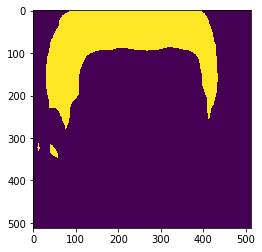

In [37]:
seg_sample = torch.Tensor(y_preds[0]).squeeze()
part_seg_mask = load_segmentation_part(seg_sample, hair, class_name)

plt.imshow(part_seg_mask)

In [20]:
load_segmentation_part(ori_mask, class_name=)

[]

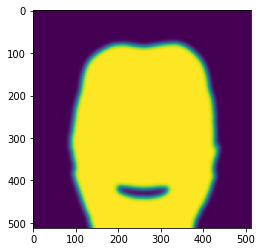

In [17]:
plt.imshow(cv2.GaussianBlur(ori_mask / 255, (blur_size, blur_size), sigmaX=0))

In [1]:
new_mask = fg_mask[...]

# mask = new_mask[..., 0].astype(np.uint8)
# mask.max()
# img_mask = mask * 255
plt.imshow(fg_masks[0])

NameError: name 'fg_mask' is not defined

In [149]:
# img = cv2.imread('/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/out/deform/v0.99/size999_seed1_celeba_z_8w_crossInstance_randz/template.png')
img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
img.shape
# BGR ORDER

(512, 512, 3)

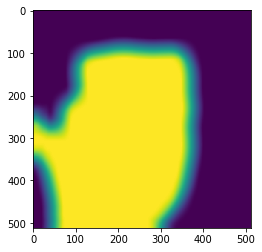

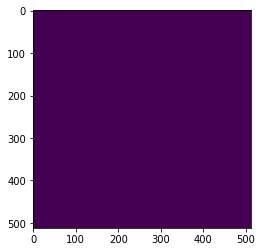

In [61]:
blur_mask = (blur>0) ^ (blur==1)
plt.imshow(blur_mask)

In [64]:
# (blur==0).sum() + (blur==1).sum()
# 512*512

262144

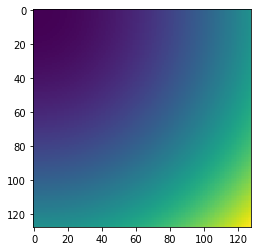

In [50]:
# blending
# 1. plt.imshow()
h, w = 128, 128
diffusion = np.zeros((h, w))

for i in range(h):
    for j in range(w):
        diffusion[i][j] = i**2 + j**2
        
plt.imshow(diffusion)

In [27]:
mask.mean()

0.4954986572265625

In [25]:
blur.mean()

0.4953498840332031

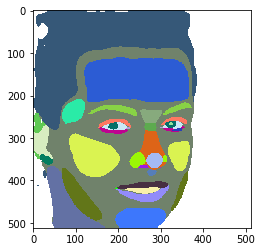

In [12]:
import matplotlib.pyplot as plt
plt.imshow(colorize_preds[0])

In [27]:
# plt.imsave('pred_seg.png', colorize_pred)
plt.imsave(save_base_dir / f'{img_name}', colorize_pred)
np.save(save_base_dir / f'{img_name}.npy', y_pred)

In [57]:
testing_path='/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/instance_lib/'

In [119]:
test = glob.glob(testing_path + "**/*.png", recursive=True)

In [134]:
Path(test[0]).name

'img_seed_1_1.0707963267948966.png'

In [ ]:
# https://docs.python.org/3/library/pathlib.html#module-pathlib
.name
.parents
.root

<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
<ipython-input-165-3c4413ce61a5>:1: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [1,2,3][1,2]


TypeError: list indices must be integers or slices, not tuple

In [208]:
Path('/mnt/lustre/yslan/Repo/3D/correspondence/pigan_densecorr/imgs/newmodel/instance_lib/212/4.png').parents[1].name

'instance_lib'

In [ ]:
# loss 